<a href="https://colab.research.google.com/github/HaoyuGu1/DPT/blob/main/train_20251213_CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import model_20250901_2mods
import simulate
from sklearn.metrics import r2_score
import importlib


In [ ]:
sample_data = np.load(r"C:\Users\haley\Documents\KECC_BNN\train_cnn\circle_square_data.npz")

In [ ]:
print(sample_data.files)

['v_list1', 'v_list2', 'true_beta1', 'true_beta2', 'img1_test', 'img2_test', 'y_test', 'img1_train_2000', 'img2_train_2000', 'y_train_2000']


In [ ]:
device = "cpu"
# random_seed = 2025
# r2 = 0.5
# n = 1000
# dim = 112
# coord, true_beta, img_data, y = simulate.simulate_data(n, r2, dim, random_seed)


# ----- coordinates (same for all samples) -----
coord1 = sample_data["v_list1"]   # modality 1 pixel locations
coord2 = sample_data["v_list2"]   # modality 2 pixel locations

# ----- true beta (ground truth regions) -----
true_beta1 = sample_data["true_beta1"]
true_beta2 = sample_data["true_beta2"]

# ----- training subset (first 500) -----
n_train = 500

img1_train = sample_data["img1_train_2000"][:n_train]
img2_train = sample_data["img2_train_2000"][:n_train]
y_train    = sample_data["y_train_2000"][:n_train]


In [ ]:
coord = {
    "mod1": coord1,
    "mod2": coord2,
}

true_beta = {
    "mod1": true_beta1,
    "mod2": true_beta2,
}

img_data = {
    "mod1": img1_train,
    "mod2": img2_train,
}

y = y_train

In [ ]:
# verify sample shape
for k in sample_data.files:
    arr = sample_data[k]
    print(f"{k:20s} shape={arr.shape}, dtype={arr.dtype}")


v_list1              shape=(10000, 2), dtype=float64
v_list2              shape=(40000, 2), dtype=float64
true_beta1           shape=(10000,), dtype=int64
true_beta2           shape=(40000,), dtype=bool
img1_test            shape=(2000, 10000), dtype=float64
img2_test            shape=(2000, 40000), dtype=float64
y_test               shape=(2000,), dtype=float64
img1_train_2000      shape=(2000, 10000), dtype=float64
img2_train_2000      shape=(2000, 40000), dtype=float64
y_train_2000         shape=(2000,), dtype=float64


In [ ]:
# test reshaping to 2D
img1_flat = sample_data["img1_train_2000"][0]  # shape (10000,)
img2_flat = sample_data["img2_train_2000"][0]  # shape (40000,)

img1_2d = img1_flat.reshape(100, 100)
img2_2d = img2_flat.reshape(200, 200)

print(img1_2d.shape, img2_2d.shape)

(100, 100) (200, 200)


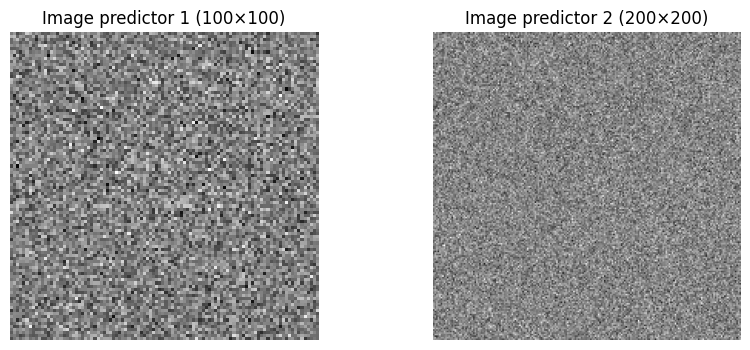

In [ ]:

fig, axes = plt.subplots(1, 2, figsize=(10, 4))

axes[0].imshow(img1_2d, cmap="gray")
axes[0].set_title("Image predictor 1 (100×100)")
axes[0].axis("off")

axes[1].imshow(img2_2d, cmap="gray")
axes[1].set_title("Image predictor 2 (200×200)")
axes[1].axis("off")

plt.show()

In [ ]:
print(type(true_beta))
print(true_beta.keys())

<class 'dict'>
dict_keys(['mod1', 'mod2'])


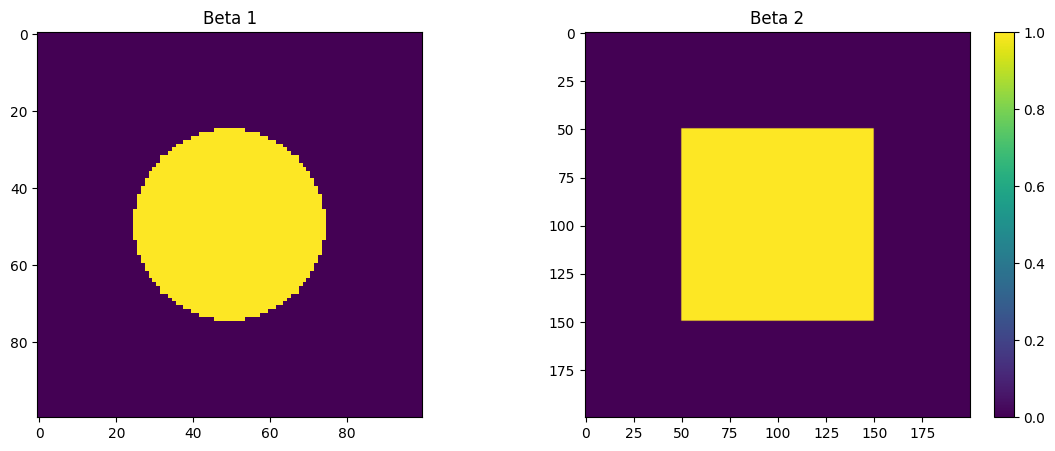

In [ ]:
dim1 = 100
dim2 = 200

fig, axs = plt.subplots(1, 2, figsize = (14,5))
axs[0].imshow(true_beta["mod1"].reshape(dim1, dim1))
axs[0].set_title("Beta 1")

cax = axs[1].imshow(true_beta["mod2"].reshape(dim2, dim2))
axs[1].set_title("Beta 2")

fig.colorbar(cax, ax = axs[1])
plt.show()



In [ ]:
train_size = 500

img1 = sample_data["img1_train_2000"][:train_size].reshape(
    train_size, 1, 100, 100
)

img2 = sample_data["img2_train_2000"][:train_size].reshape(
    train_size, 1, 200, 200
)

y = sample_data["y_train_2000"][:train_size].reshape(-1, 1)

# ---- test data (always use full 2000) ----
img1_test = sample_data["img1_test"].reshape(
    2000, 1, 100, 100
)
img2_test = sample_data["img2_test"].reshape(
    2000, 1, 200, 200
)
y_test = sample_data["y_test"].reshape(-1, 1)

In [ ]:
img1_train = torch.tensor(img1_train, dtype=torch.float32).to(device)
img2_train = torch.tensor(img2_train, dtype=torch.float32).to(device)
y_train    = torch.tensor(y_train, dtype=torch.float32).to(device)

img1_test  = torch.tensor(img1_test, dtype=torch.float32).to(device)
img2_test  = torch.tensor(img2_test, dtype=torch.float32).to(device)
y_test     = torch.tensor(y_test, dtype=torch.float32).to(device)

In [ ]:
from torch.utils.data import Dataset

class MultiModalDataset(Dataset):
    def __init__(self, img1, img2, y):
        self.img1 = img1
        self.img2 = img2
        self.y = y

    def __len__(self):
        return self.y.shape[0]

    def __getitem__(self, idx):
        return self.img1[idx], self.img2[idx], self.y[idx]


In [ ]:
train_dataset = MultiModalDataset(img1_train, img2_train, y_train)
test_dataset  = MultiModalDataset(img1_test, img2_test, y_test)

In [ ]:
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, TensorDataset
import torch.optim as optim

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader  = DataLoader(test_dataset, batch_size=64, shuffle=False)


In [ ]:
# from sklearn.model_selection import train_test_split
# from torch.utils.data import DataLoader, TensorDataset
# import torch.optim as optim

# image_data_0_reshaped = img_data[0].reshape(n, dim, dim)
# image_data_1_reshaped = img_data[1].reshape(n, dim, dim)

# stacked_img = np.concatenate([image_data_0_reshaped, image_data_1_reshaped], axis = 1)
# stacked_img = stacked_img[:, np.newaxis, :, :]

# y = y.reshape(-1, 1)
# y_tensor = torch.tensor(y, dtype = torch.float32).to(device)
# stacked_img_tensor = torch.tensor(stacked_img, dtype = torch.float32).to(device)

# torch.manual_seed(random_seed)
# np.random.seed(random_seed)

# X_train, X_test, y_train, y_test = train_test_split(stacked_img_tensor, y_tensor, test_size = 0.2, random_state = random_seed)
# train_dataset = TensorDataset(X_train, y_train)
# test_dataset =  TensorDataset(X_test, y_test)

# train_loader = DataLoader(train_dataset, batch_size = 64, shuffle = True)
# test_loader = DataLoader(test_dataset, batch_size = 64, shuffle = False)

In [ ]:
import torch
from torch.utils.data import DataLoader
import torch.optim as optim
import numpy as np
from sklearn.metrics import r2_score
import matplotlib.pyplot as plt

def train_cnn_model(model_class,
                    lr=0.001,
                    weight_decay=0.0,
                    num_epochs=20,
                    train_loader=None,
                    test_loader=None,
                    device='cuda' if torch.cuda.is_available() else 'cpu',
                    verbose=True,
                    plot_results=True):
    """
    Train a multi-modal CNN with two image modalities.

    Args:
        model_class: CNN model class (must accept two image inputs)
        lr: learning rate
        weight_decay: L2 regularization
        num_epochs: number of epochs
        train_loader: training DataLoader (returns img1, img2, y)
        test_loader: testing DataLoader (returns img1, img2, y)
        device: 'cuda' or 'cpu'
        verbose: print progress
        plot_results: plot loss and R² curves

    Returns:
        Dictionary with trained model, metrics, and best epoch info
    """

    # Initialize model, criterion, optimizer
    cnn = model_class().to(device)
    criterion = torch.nn.MSELoss()
    optimizer = optim.Adam(cnn.parameters(), lr=lr, weight_decay=weight_decay)

    # Track metrics
    train_losses, test_losses = [], []
    train_r2_scores, test_r2_scores = [], []

    best_epoch = 0
    best_test_loss = float('inf')
    best_test_r2 = -float('inf')

    for epoch in range(num_epochs):
        # --- Training Phase ---
        cnn.train()
        running_loss = 0.0
        y_pred, y_true = [], []

        for img1_batch, img2_batch, y_batch in train_loader:
            img1_batch = img1_batch.to(device)
            img2_batch = img2_batch.to(device)
            y_batch = y_batch.to(device)

            optimizer.zero_grad()
            y_hat = cnn(img1_batch, img2_batch)
            loss = criterion(y_hat, y_batch)
            loss.backward()
            optimizer.step()

            with torch.no_grad():
                running_loss += loss.item()
                y_pred.extend(y_hat.detach().cpu().numpy().flatten())
                y_true.extend(y_batch.cpu().numpy().flatten())

        epoch_train_loss = running_loss / len(train_loader)
        train_losses.append(epoch_train_loss)
        train_r2 = r2_score(y_true, y_pred)
        train_r2_scores.append(train_r2)

        # --- Testing Phase ---
        cnn.eval()
        test_running_loss = 0.0
        test_pred, test_true = [], []

        with torch.no_grad():
            for img1_batch, img2_batch, y_batch in test_loader:
                img1_batch = img1_batch.to(device)
                img2_batch = img2_batch.to(device)
                y_batch = y_batch.to(device)

                y_hat = cnn(img1_batch, img2_batch)
                loss = criterion(y_hat, y_batch)

                test_running_loss += loss.item()
                test_pred.extend(y_hat.detach().cpu().numpy().flatten())
                test_true.extend(y_batch.cpu().numpy().flatten())

        epoch_test_loss = test_running_loss / len(test_loader)
        test_losses.append(epoch_test_loss)
        test_r2 = r2_score(test_true, test_pred)
        test_r2_scores.append(test_r2)

        # Update best epoch
        if epoch_test_loss < best_test_loss:
            best_test_loss = epoch_test_loss
            best_test_r2 = test_r2
            best_epoch = epoch + 1

        if verbose:
            print(f"Epoch {epoch+1}/{num_epochs} - "
                  f"Train Loss: {epoch_train_loss:.4f}, Train R²: {train_r2:.4f} | "
                  f"Test Loss: {epoch_test_loss:.4f}, Test R²: {test_r2:.4f}")

    # --- Plot metrics ---
    if plot_results:
        plt.figure(figsize=(12,5))

        # Loss
        plt.subplot(1,2,1)
        plt.plot(train_losses, label='Train Loss')
        plt.plot(test_losses, label='Test Loss')
        plt.xlabel('Epoch')
        plt.ylabel('MSE Loss')
        plt.title('Training & Test Loss')
        plt.legend()

        # R²
        plt.subplot(1,2,2)
        plt.plot(train_r2_scores, label='Train R²')
        plt.plot(test_r2_scores, label='Test R²')
        plt.xlabel('Epoch')
        plt.ylabel('R² Score')
        plt.title('R² Scores')
        plt.legend()

        plt.tight_layout()
        plt.show()

    # --- Return results ---
    return {
        'model': cnn,
        'train_losses': train_losses,
        'test_losses': test_losses,
        'train_r2_scores': train_r2_scores,
        'test_r2_scores': test_r2_scores,
        'best_epoch': best_epoch,
        'best_test_loss': best_test_loss,
        'best_test_r2': best_test_r2,
        'final_train_loss': train_losses[-1],
        'final_test_loss': test_losses[-1],
        'final_train_r2': train_r2_scores[-1],
        'final_test_r2': test_r2_scores[-1]
    }


In [ ]:
import model_20250901_2mods
importlib.reload(model_20250901_2mods)      # Force-reload the module
from model_20250901_2mods import CNN_3_3_16_512, CNN_3_3_16_256 , CNN_3_3_8_256, CNN_2_2_8_256, CNN_3_3_16_128       # Import the updated class

In [ ]:
# # session 1
# results = train_cnn_model(model_class=model_20250901.CNN_3_3_16_512,
#                         lr=0.001,
#                         weight_decay=0.0,
#                         num_epochs=20,
#                         train_loader=train_loader,
#                         test_loader=test_loader)

In [ ]:
# session 2
results = train_cnn_model(model_class=model_20250901_2mods.CNN_3_3_16_512,
                        lr=0.0001,
                        weight_decay=0.0,
                        num_epochs=20,
                        train_loader=train_loader,
                        test_loader=test_loader)

RuntimeError: Expected 3D (unbatched) or 4D (batched) input to conv2d, but got input of size: [64, 10000]

In [ ]:
# # session 3
# results = train_cnn_model(model_class=model_20250901.CNN_2_2_16_512,
#                         lr=0.001,
#                         weight_decay=0.0,
#                         num_epochs=20,
#                         train_loader=train_loader,
#                         test_loader=test_loader)

In [ ]:
# # session 4
# results = train_cnn_model(model_class=model_20250901.CNN_2_2_16_512,
#                         lr=0.0001,
#                         weight_decay=0.0,
#                         num_epochs=20,
#                         train_loader=train_loader,
#                         test_loader=test_loader)

In [ ]:
# session 5
results = train_cnn_model(model_class=model_20250901_2mods.CNN_3_3_16_256,
                        lr=0.001,
                        weight_decay=0.0,
                        num_epochs=20,
                        train_loader=train_loader,
                        test_loader=test_loader)

In [ ]:
# # session 6

# results = train_cnn_model(model_class=model_20250901.CNN_3_3_16_256,
#                         lr=0.0001,
#                         weight_decay=0.0,
#                         num_epochs=20,
#                         train_loader=train_loader,
#                         test_loader=test_loader)

In [ ]:
# # session 7
# results = train_cnn_model(model_class=model_20250901.CNN_2_2_16_256,
#                         lr=0.001,
#                         weight_decay=0.0,
#                         num_epochs=20,
#                         train_loader=train_loader,
#                         test_loader=test_loader)

In [ ]:
# # session 8
# results = train_cnn_model(model_class=model_20250901.CNN_2_2_16_256,
#                         lr=0.0001,
#                         weight_decay=0.0,
#                         num_epochs=20,
#                         train_loader=train_loader,
#                         test_loader=test_loader)

In [ ]:
# # session 9

# results = train_cnn_model(model_class=model_20250901.CNN_3_3_8_512,
#                         lr=0.001,
#                         weight_decay=0.0,
#                         num_epochs=20,
#                         train_loader=train_loader,
#                         test_loader=test_loader)

In [ ]:
# # session 10

# results = train_cnn_model(model_class=model_20250901.CNN_3_3_8_512,
#                         lr=0.0001,
#                         weight_decay=0.0,
#                         num_epochs=20,
#                         train_loader=train_loader,
#                         test_loader=test_loader)

In [ ]:
# # session 11
# results = train_cnn_model(model_class=model_20250901.CNN_2_2_8_512,
#                         lr=0.001,
#                         weight_decay=0.0,
#                         num_epochs=20,
#                         train_loader=train_loader,
#                         test_loader=test_loader)

In [ ]:
# # session 12
# results = train_cnn_model(model_class=model_20250901.CNN_2_2_8_512,
#                         lr=0.0001,
#                         weight_decay=0.0,
#                         num_epochs=20,
#                         train_loader=train_loader,
#                         test_loader=test_loader)

In [ ]:
# session 13
results = train_cnn_model(model_class=model_20250901_2mods.CNN_3_3_8_256,
                        lr=0.001,
                        weight_decay=0.0,
                        num_epochs=20,
                        train_loader=train_loader,
                        test_loader=test_loader)

In [ ]:
# # session 14
# results = train_cnn_model(model_class=model_20250901.CNN_3_3_8_256,
#                         lr=0.0001,
#                         weight_decay=0.0,
#                         num_epochs=20,
#                         train_loader=train_loader,
#                         test_loader=test_loader)

In [ ]:
# session 15
results = train_cnn_model(model_class=model_20250901_2mods.CNN_2_2_8_256,
                        lr=0.001,
                        weight_decay=0.0,
                        num_epochs=20,
                        train_loader=train_loader,
                        test_loader=test_loader)

In [ ]:
# # session 16
# results = train_cnn_model(model_class=model_20250901.CNN_2_2_8_256,
#                         lr=0.0001,
#                         weight_decay=0.0,
#                         num_epochs=20,
#                         train_loader=train_loader,
#                         test_loader=test_loader)

In [ ]:
# # session 17
# results = train_cnn_model(model_class=model_20250901.CNN_3_3_8_128,
#                         lr=0.001,
#                         weight_decay=0.0,
#                         num_epochs=20,
#                         train_loader=train_loader,
#                         test_loader=test_loader)

In [ ]:
# # session 18
# results = train_cnn_model(model_class=model_20250901.CNN_3_3_8_128,
#                         lr=0.0001,
#                         weight_decay=0.0,
#                         num_epochs=20,
#                         train_loader=train_loader,
#                         test_loader=test_loader)

In [ ]:
# # session 19
# results = train_cnn_model(model_class=model_20250901.CNN_2_2_8_128,
#                         lr=0.001,
#                         weight_decay=0.0,
#                         num_epochs=20,
#                         train_loader=train_loader,
#                         test_loader=test_loader)

In [ ]:
# # session 20
# results = train_cnn_model(model_class=model_20250901.CNN_2_2_8_128,
#                         lr=0.0001,
#                         weight_decay=0.0,
#                         num_epochs=20,
#                         train_loader=train_loader,
#                         test_loader=test_loader)

In [ ]:
# session 21
results = train_cnn_model(model_class=model_20250901_2mods.CNN_3_3_16_128,
                        lr=0.001,
                        weight_decay=0.0,
                        num_epochs=20,
                        train_loader=train_loader,
                        test_loader=test_loader)

In [ ]:
# # session 22
# results = train_cnn_model(model_class=model_20250901.CNN_3_3_16_128,
#                         lr=0.0001,
#                         weight_decay=0.0,
#                         num_epochs=20,
#                         train_loader=train_loader,
#                         test_loader=test_loader)

In [ ]:
# # session 23
# results = train_cnn_model(model_class=model_20250901.CNN_2_2_16_128,
#                         lr=0.001,
#                         weight_decay=0.0,
#                         num_epochs=20,
#                         train_loader=train_loader,
#                         test_loader=test_loader)

In [ ]:
# # session 24
# results = train_cnn_model(model_class=model_20250901.CNN_2_2_16_128,
#                         lr=0.0001,
#                         weight_decay=0.0,
#                         num_epochs=20,
#                         train_loader=train_loader,
#                         test_loader=test_loader)